<div style="text-align: right">   </div>


Introduction to Deep Learning (2023) &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| &nbsp;
-------|-------------------
**Assignment 2 - Recurrent Neural Networks** | <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/UniversiteitLeidenLogo.svg/1280px-UniversiteitLeidenLogo.svg.png" width="300">



# Introduction


The goal of this assignment is to learn how to use encoder-decoder recurrent neural networks (RNNs). Specifically we will be dealing with a sequence to sequence problem and try to build recurrent models that can learn the principles behind simple arithmetic operations (**integer addition, subtraction and multiplication.**).

<img src="https://i.ibb.co/5Ky5pbk/Screenshot-2023-11-10-at-07-51-21.png" alt="Screenshot-2023-11-10-at-07-51-21" border="0" width="500"></a>

In this assignment you will be working with three different kinds of models, based on input/output data modalities:
1. **Text-to-text**: given a text query containing two integers and an operand between them (+ or -) the model's output should be a sequence of integers that match the actual arithmetic result of this operation
2. **Image-to-text**: same as above, except the query is specified as a sequence of images containing individual digits and an operand.
3. **Text-to-image**: the query is specified in text format as in the text-to-text model, however the model's output should be a sequence of images corresponding to the correct result.


### Description**
Let us suppose that we want to develop a neural network that learns how to add or subtract
two integers that are at most two digits long. For example, given input strings of 5 characters: ‘81+24’ or
’41-89’ that consist of 2 two-digit long integers and an operand between them, the network should return a
sequence of 3 characters: ‘105 ’ or ’-48 ’ that represent the result of their respective queries. Additionally,
we want to build a model that generalizes well - if the network can extract the underlying principles behind
the ’+’ and ’-’ operands and associated operations, it should not need too many training examples to generate
valid answers to unseen queries. To represent such queries we need 13 unique characters: 10 for digits (0-9),
2 for the ’+’ and ’-’ operands and one for whitespaces ’ ’ used as padding.
The example above describes a text-to-text sequence mapping scenario. However, we can also use different
modalities of data to represent our queries or answers. For that purpose, the MNIST handwritten digit
dataset is going to be used again, however in a slightly different format. The functions below will be used to create our datasets.

---

*To work on this notebook you should create a copy of it.*


# Function definitions for creating the datasets

First we need to create our datasets that are going to be used for training our models.

In order to create image queries of simple arithmetic operations such as '15+13' or '42-10' we need to create images of '+' and '-' signs using ***open-cv*** library. We will use these operand signs together with the MNIST dataset to represent the digits.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, RNN, LSTM, Flatten, TimeDistributed, LSTMCell
from tensorflow.keras.layers import RepeatVector, Conv2D, SimpleRNN, GRU, Reshape, ConvLSTM2D, Conv2DTranspose

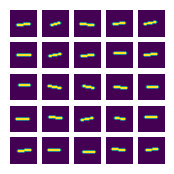

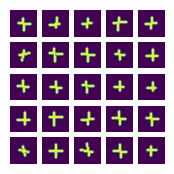

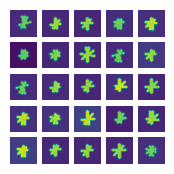

In [2]:
from scipy.ndimage import rotate
# Create plus/minus operand signs
def generate_images(number_of_images=50, sign='-'):

    blank_images = np.zeros([number_of_images, 28, 28])  # Dimensionality matches the size of MNIST images (28x28)
    x = np.random.randint(12, 16, (number_of_images, 2)) # Randomized x coordinates
    y1 = np.random.randint(6, 10, number_of_images)      # Randomized y coordinates
    y2 = np.random.randint(18, 22, number_of_images)     # -//-

    for i in range(number_of_images): # Generate n different images
        cv2.line(blank_images[i], (y1[i], x[i,0]), (y2[i], x[i, 1]), (255,0,0), 2, cv2.LINE_AA)     # Draw lines with randomized coordinates
        if sign == '+':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA) # Draw lines with randomized coordinates
        if sign == '*':
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            # Rotate 45 degrees
            blank_images[i] = rotate(blank_images[i], -45, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)
            blank_images[i] = rotate(blank_images[i], -45, reshape=False)
            cv2.line(blank_images[i], (x[i,0], y1[i]), (x[i, 1], y2[i]), (255,0,0), 2, cv2.LINE_AA)

    return blank_images

def show_generated(images, n=5):
    plt.figure(figsize=(2, 2))
    for i in range(n**2):
        plt.subplot(n, n, i+1)
        plt.axis('off')
        plt.imshow(images[i])
    plt.show()

show_generated(generate_images())
show_generated(generate_images(sign='+'))
show_generated(generate_images(sign='*'))

In [3]:
def create_data(highest_integer, unique_char, max_ans_len, num_addends=2, operands=['+', '-']):
    """
    Creates the following data for all pairs of integers up to [1:highest integer][+/-][1:highest_integer]:

    @return:
    X_text: '151+ 21' -> text query of an arithmetic operation (7 )
    X_img : Stack of MNIST images corresponding to the query (7 x 28 x 28) -> sequence of 7 images of size 28x28
    y_text: ' 172' -> answer of the arithmetic text query
    y_img :  Stack of MNIST images corresponding to the answer (4 x 28 x 28)

    Images for digits are picked randomly from the whole MNIST dataset.
    """

    num_indices = [np.where(MNIST_labels==x) for x in range(10)]
    num_data = [MNIST_data[inds] for inds in num_indices]
    image_mapping = dict(zip(unique_char[:10], num_data))
    image_mapping['-'] = generate_images()
    image_mapping['+'] = generate_images(sign='+')
    image_mapping['*'] = generate_images(sign='*')
    image_mapping[' '] = np.zeros([1, 28, 28])

    X_text, X_img, y_text, y_img = [], [], [], []

    for i in range(highest_integer + 1):      # First addend
        for j in range(highest_integer + 1):  # Second addend
            # for k in range(highest_integer + 1):  # Third addend
                # i_char = to_padded_chars(i, max_len=max_int_length) # convert integers to strings of constant length [20->' 20']
                # j_char = to_padded_chars(j, max_len=max_int_length, pad_right=True)
                # k_char = to_padded_chars(k, max_len=max_int_length, pad_right=True)

            for sign in operands: # Create all possible combinations of operands
                query_string = to_padded_chars(str(i) + sign + str(j), max_len=max_query_length, pad_right=True)
                query_image = []
                for n, char in enumerate(query_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    query_image.append(image_set[index].squeeze())

                result = eval(query_string)
                result_string = to_padded_chars(result, max_len=max_ans_len, pad_right=True)
                result_image = []
                for n, char in enumerate(result_string):
                    image_set = image_mapping[char]
                    index = np.random.randint(0, len(image_set), 1)
                    result_image.append(image_set[index].squeeze())

                X_text.append(query_string)
                X_img.append(np.stack(query_image))
                y_text.append(result_string)
                y_img.append(np.stack(result_image))

    return np.stack(X_text), np.stack(X_img)/255., np.stack(y_text), np.stack(y_img)/255.

def to_padded_chars(integer, max_len, pad_right=False):
    """
    Returns a string of len()=max_len, containing the integer padded with ' ' on either right or left side
    """
    length = len(str(integer))
    padding = (max_len - length) * ' '
    if pad_right:
        return str(integer) + padding
    else:
        return padding + str(integer)


# Creating our data

The dataset consists of 20000 samples that (additions and subtractions between all 2-digit integers) and they have two kinds of inputs and label modalities:

  **X_text**: strings containing queries of length 7: ['  1+1  ', '11-18', ...]

  **X_image**: a stack of images representing a single query, dimensions: [5, 28, 28]

  **y_text**: strings containing answers of length 3: ['  2', '156']

  **y_image**: a stack of images that represents the answer to a query, dimensions: [3, 28, 28]

11490434/11490434 [==============================] - 0s 0us/step
(20000,) (20000, 5, 28, 28) (20000,) (20000, 3, 28, 28)
Query #7291

X_text: "36-45" = y_text: "-9 "


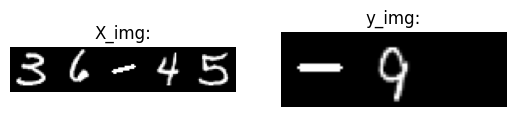

Query #2804

X_text: "14+2 " = y_text: "16 "


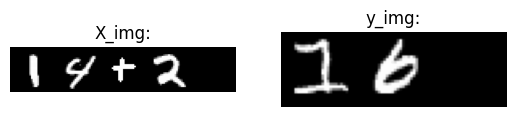

Query #5704

X_text: "28+52" = y_text: "80 "


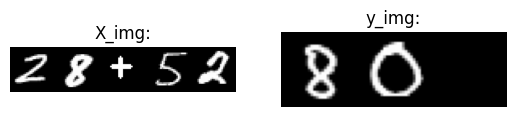

Query #3185

X_text: "15-92" = y_text: "-77"


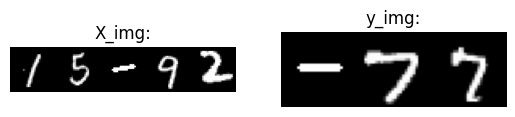

Query #7010

X_text: "35+5 " = y_text: "40 "


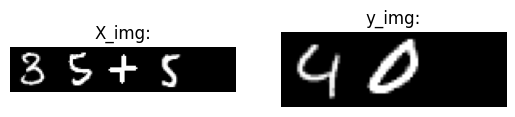

Query #5381

X_text: "26-90" = y_text: "-64"


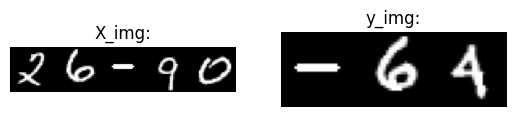

Query #3900

X_text: "19+50" = y_text: "69 "


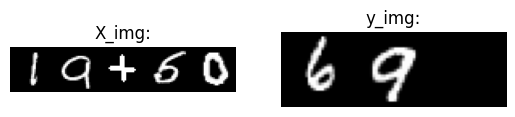

Query #2082

X_text: "10+41" = y_text: "51 "


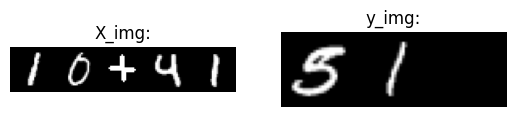

Query #7579

X_text: "37-89" = y_text: "-52"


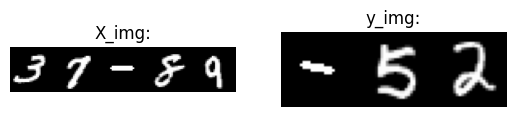

Query #6200

X_text: "31+0 " = y_text: "31 "


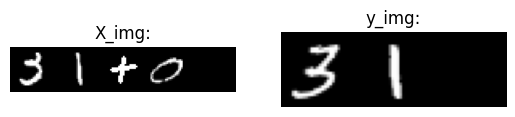

In [4]:
# Illustrate the generated query/answer pairs

unique_characters = '0123456789+- '       # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length = max_int_length + 1    # Maximum length of the answer string (the longest resulting query string is ' 1-99'='-98')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text, X_img, y_text, y_img = create_data(
    highest_integer, unique_characters, max_answer_length
)
print(X_text.shape, X_img.shape, y_text.shape, y_img.shape)


# Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img, y_img]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text[n]}" = y_text: "{y_text[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

# Helper functions

The functions below will help with input/output of the data.

In [5]:
# One-hot encoding/decoding the text queries/answers so that they can be processed using RNNs
# You should use these functions to convert your strings and read out the output of your networks

def encode_labels(labels, unique_char):
  n = len(labels)
  length = len(labels[0])
  char_map = dict(zip(unique_char, range(len(unique_char))))
  one_hot = np.zeros([n, length, len(unique_char)])
  for i, label in enumerate(labels):
      m = np.zeros([length, len(unique_char)])
      for j, char in enumerate(label):
          m[j, char_map[char]] = 1
      one_hot[i] = m

  return one_hot


def decode_labels(labels, unique_char):
    pred = np.argmax(labels, axis=-1)
    preds = []

    for single_pred in pred:
      predicted = ''.join([unique_char[i] for i in single_pred])
      preds.append(predicted)

    return preds

X_text_onehot = encode_labels(X_text, unique_characters)
y_text_onehot = encode_labels(y_text, unique_characters)

print(X_text_onehot.shape, y_text_onehot.shape)

(20000, 5, 13) (20000, 3, 13)


---
---

# Part 1: Text-to-text RNN model

The following code showcases how Recurrent Neural Networks (RNNs) are built using Keras. Several new layers are going to be used:

1. LSTM
2. TimeDistributed
3. RepeatVector

The code cell below explains each of these new components.

<img src="https://i.ibb.co/NY7FFTc/Screenshot-2023-11-10-at-09-27-25.png" alt="Screenshot-2023-11-10-at-09-27-25" border="0" width="500"></a>


In [6]:
def build_text2text_model(unique_char, max_ans_len):

    # We start by initializing a sequential model
    text2text = tf.keras.Sequential()

    # "Encode" the input sequence using an RNN, producing an output of size 256.
    # In this case the size of our input vectors is [5, 13] as we have queries
    # of length 5 and 13 unique characters. Each of these 5 elements in the
    # query will be fed to the network one by one,
    # as shown in the image above (except with 5 elements).
    # Hint: In other applications, where your input sequences have a variable
    # length (e.g. sentences), you would use input_shape=(None, unique_characters).
    text2text.add(LSTM(256, input_shape=(None, len(unique_char))))

    # As the decoder RNN's input, repeatedly provide with the last output of RNN for each time step. Repeat 3 times as that's the maximum length of the output (e.g. '  1-99' = '-98')
    # when using 2-digit integers in queries. In other words, the RNN will always produce 3 characters as its output.
    text2text.add(RepeatVector(max_ans_len))

    # By setting return_sequences to True, return not only the last output but all the outputs so far in the form of (num_samples, timesteps, output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    text2text.add(LSTM(256, return_sequences=True))

    # Apply a dense layer to every temporal slice of an input. For each of step of the output sequence, decide which character should be chosen.
    text2text.add(TimeDistributed(Dense(len(unique_char), activation='softmax')))

    # Next we compile the model using categorical crossentropy as our loss function.
    text2text.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    text2text.summary()

    return text2text

In [7]:
# Your code (look at the assignment description for your tasks for text-to-text model):
test_sizes = [0.30, 0.50, 0.70, 0.90]
t2t_models = []
losses = []
accuracies = []
predictions_data = []
y_test_data = []

for i in test_sizes:
  X_train, X_test, y_train, y_test = train_test_split(X_text_onehot, y_text_onehot,
                                                      test_size=i)
  text2text = build_text2text_model(unique_characters, max_answer_length)
  text2text.fit(X_train, y_train, epochs=30)

  loss, accuracy = text2text.evaluate(X_test, y_test)

  predictions = text2text.predict(X_test)
  pred_label = decode_labels(predictions, unique_characters)
  target_label = decode_labels(y_test, unique_characters)
  input_text = decode_labels(X_test, unique_characters)

  # Print some of the false predictions
  for j in range(10):
    if pred_label[j] != target_label[j]:
      print('Target output:    ' + input_text[j] + ' = ' + target_label[j] +
            '\nPredicted output: ' + input_text[j] + ' = ' + pred_label[j] + '\n')

  t2t_models.append(text2text)
  losses.append(loss)
  accuracies.append(accuracy)
  predictions_data.append(predictions)
  y_test_data.append(y_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               276480    
                                                                 
 repeat_vector (RepeatVecto  (None, 3, 256)            0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 3, 256)            525312    
                                                                 
 time_distributed (TimeDist  (None, 3, 13)             3341      
 ributed)                                                        
                                                                 
Total params: 805133 (3.07 MB)
Trainable params: 805133 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
438/438 [

What we see from the models is that that the accuracy decreases when the test size increases, as expected.

| Test size | 30%    | 50%    | 70%    | 90%    |
|-----------|--------|--------|--------|--------|
|  Accuarcy | 0.9756 | 0.9744 | 0.8960 | 0.6338 |

In [8]:
def get_mismatches(pred, target, unique_char):
  """
  Find the predicted results that are different from the target values and
  convert them to integers. Store the non-arithmetic predictions.

  Parameters
  ----------
  pred : array
    Array containing the outputs predicted by the network.
  target : array
    Array containing the target outputs.
  unique_char : str
    String containing all the unique characters present in the data.

  Returns
  -------
  int_pred_mis : list
    List of the mismatched predictions converted to integers.
  int_target_mis : list
    List of the target outputs corresponding to the mismatched predictions
    converted to integers.
  non_ints : list
    List of predictions that don't contain any numbers.

  """
  # Decode the one-hot encoded arrays to strings
  pred_label = decode_labels(pred, unique_char)
  target_label = decode_labels(target, unique_char)

  # Get all the indices of the mismatched predicted and target outputs
  mis_idx = [i for i in range(len(pred_label)) if pred_label[i] != target_label[i]]

  # Create new list of false predictions and their corresponding targets
  pred_mis = [pred_label[i] for i in mis_idx]
  target_mis = [target_label[i] for i in mis_idx]

  non_ints = []
  int_pred_mis = []
  int_target_mis = []

  # Strip the whitespaces around the strings
  for pred_str, target_str in zip(pred_mis, target_mis):
    pred_str.strip()
    target_str.strip()

    try:
      # Convert strings to integers
      pred_int = int(pred_str)
      target_int = int(target_str)
      int_pred_mis.append(pred_int)
      int_target_mis.append(target_int)
    except ValueError:
      # If the string doesn't contain any number, skip and store it
      non_ints.append(pred_str)

  return int_pred_mis, int_target_mis, non_ints

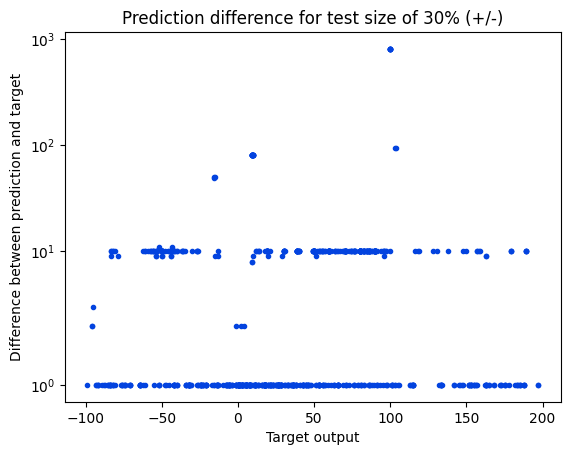

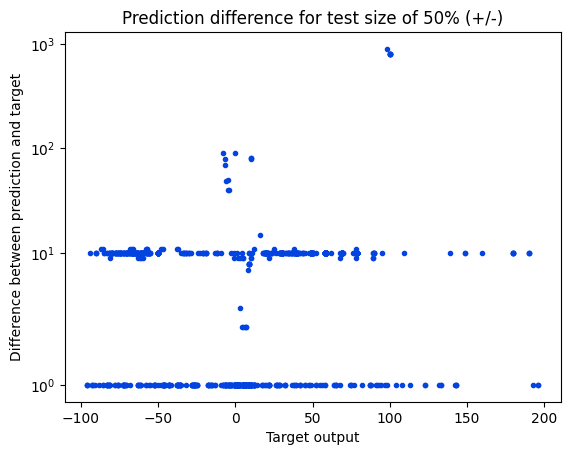

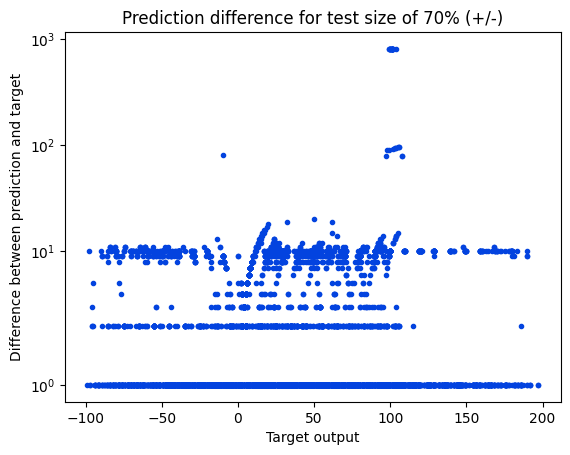

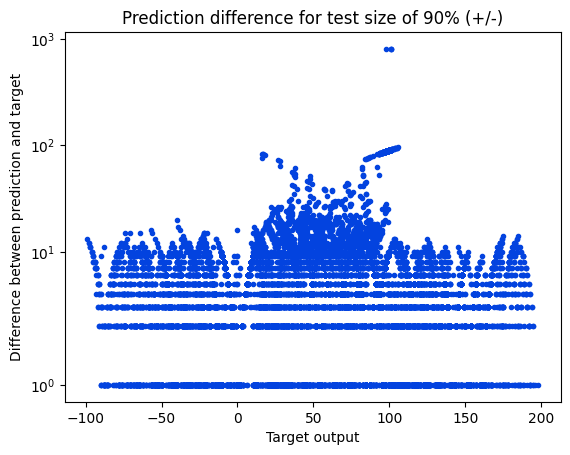

In [9]:
# Loop over each of the different test size model's data
for i in range(len(test_sizes)):
  int_pred_mis, int_target_mis, non_ints = get_mismatches(predictions_data[i], y_test_data[i], unique_characters)

  # Find the absolute difference between prediction and target
  abs_val = [abs(int_pred_mis[j]-int_target_mis[j]) for j in range(len(int_pred_mis))]

  plt.scatter(int_target_mis, abs_val, marker='.', c='xkcd:blue')
  plt.title('Prediction difference for test size of ' + f'{test_sizes[i]:.0%}' + ' (+/-)')
  plt.yscale('symlog')
  plt.xlabel('Target output')
  plt.ylabel('Difference between prediction and target')
  plt.show()

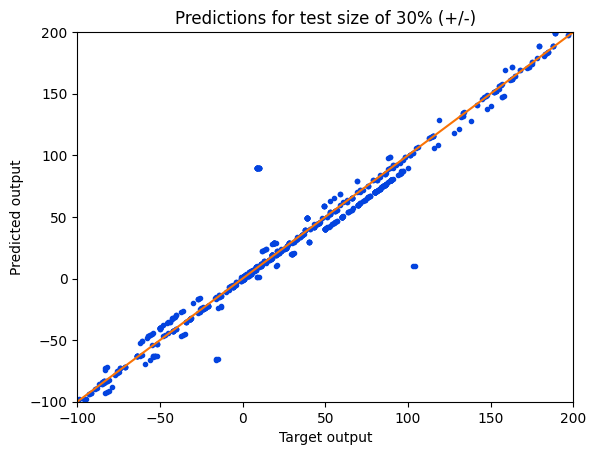

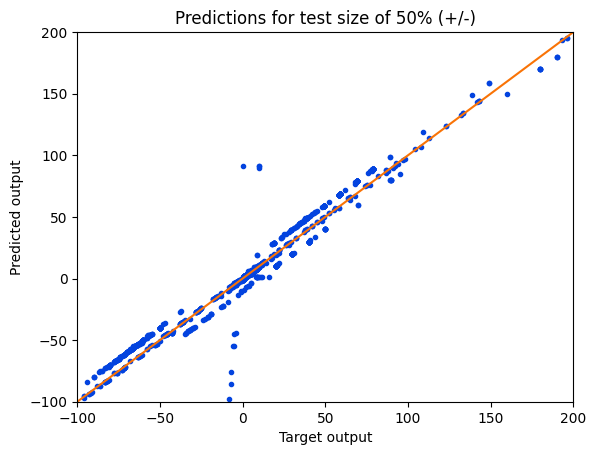

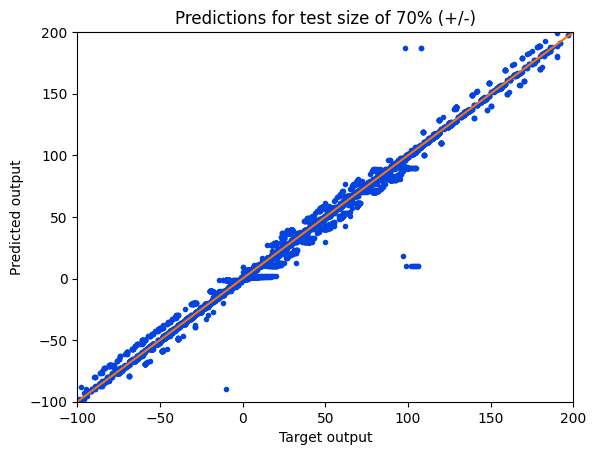

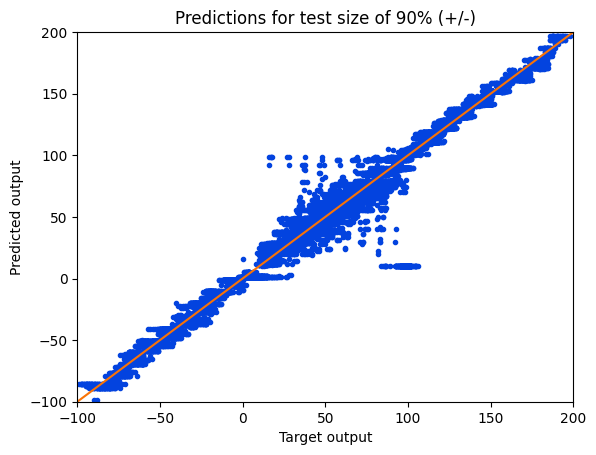

In [10]:
x = np.linspace(-100, 200, 50)

for i in range(len(test_sizes)):
  int_pred_mis, int_target_mis, non_ints = get_mismatches(predictions_data[i], y_test_data[i], unique_characters)

  plt.scatter(int_target_mis, int_pred_mis, marker='.', c='xkcd:blue')
  plt.plot(x, x, c='xkcd:orange')
  plt.title('Predictions for test size of ' + f'{test_sizes[i]:.0%}' + ' (+/-)')
  plt.xlabel('Target output')
  plt.ylabel('Predicted output')
  plt.xlim([-100, 200])
  plt.ylim([-100, 200])
  plt.show()


---
---
---

# Part 2: Multiplication
The cell below will create the multiplication dataset used in this part of the assignment.

(10000,) (10000, 5, 28, 28) (10000,) (10000, 4, 28, 28)
Query #8435

X_text: "84*35" = y_text: "2940"


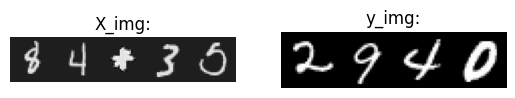

Query #2054

X_text: "20*54" = y_text: "1080"


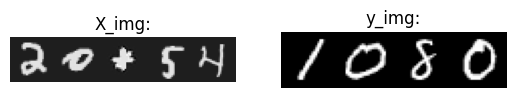

Query #573

X_text: "5*73 " = y_text: "365 "


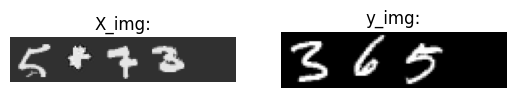

Query #3657

X_text: "36*57" = y_text: "2052"


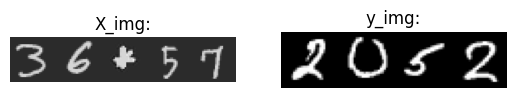

Query #1118

X_text: "11*18" = y_text: "198 "


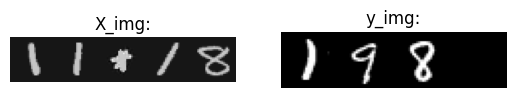

Query #9724

X_text: "97*24" = y_text: "2328"


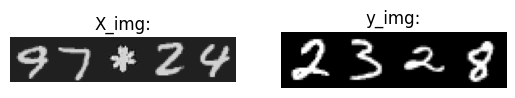

Query #7962

X_text: "79*62" = y_text: "4898"


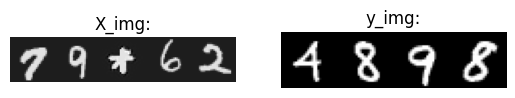

Query #5918

X_text: "59*18" = y_text: "1062"


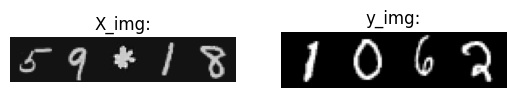

Query #7581

X_text: "75*81" = y_text: "6075"


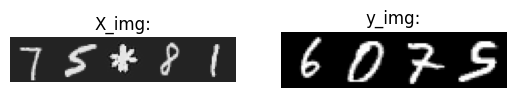

Query #2183

X_text: "21*83" = y_text: "1743"


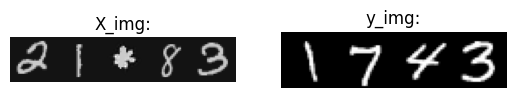

In [9]:
# Illustrate the generated query/answer pairs

unique_characters_m = '0123456789* '      # All unique characters that are used in the queries (13 in total: digits 0-9, 2 operands [+, -], and a space character ' '.)
highest_integer = 99                      # Highest value of integers contained in the queries

max_int_length = len(str(highest_integer))# Maximum number of characters in an integer
max_query_length = max_int_length * 2 + 1 # Maximum length of the query string (consists of two integers and an operand [e.g. '22+10'])
max_answer_length_m = max_int_length * 2  # Maximum length of the answer string (the longest resulting query string is '99*99'='9801')

# Create the data (might take around a minute)
(MNIST_data, MNIST_labels), _ = tf.keras.datasets.mnist.load_data()
X_text_m, X_img_m, y_text_m, y_img_m = create_data(highest_integer, unique_characters_m, max_answer_length_m, operands=['*'])
print(X_text_m.shape, X_img_m.shape, y_text_m.shape, y_img_m.shape)


# Display the samples that were created
def display_sample(n):
    labels = ['X_img:', 'y_img:']
    for i, data in enumerate([X_img_m, y_img_m]):
        plt.subplot(1,2,i+1)
        # plt.set_figheight(15)
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(np.hstack(data[n]), cmap='gray')
    print('='*50, f'\nQuery #{n}\n\nX_text: "{X_text_m[n]}" = y_text: "{y_text_m[n]}"')
    plt.show()

for _ in range(10):
    display_sample(np.random.randint(0, 10000, 1)[0])

In [12]:
# Your code
X_text_m_onehot = encode_labels(X_text_m, unique_characters_m)
y_text_m_onehot = encode_labels(y_text_m, unique_characters_m)

test_sizes = [0.30, 0.50, 0.70, 0.90]
t2t_models_m = []
losses_m = []
accuracies_m = []
predictions_data_m = []
y_test_data_m = []

for i in test_sizes:
  X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_text_m_onehot, y_text_m_onehot,
                                                      test_size=i)
  text2text_m = build_text2text_model(unique_characters_m, max_answer_length_m)
  text2text_m.fit(X_train_m, y_train_m, epochs=30)

  loss_m, accuracy_m = text2text_m.evaluate(X_test_m, y_test_m)

  predictions_m = text2text_m.predict(X_test_m)
  pred_label_m = decode_labels(predictions_m, unique_characters_m)
  target_label_m = decode_labels(y_test_m, unique_characters_m)
  input_text_m = decode_labels(X_test_m, unique_characters_m)

  # Print some of the false predictions
  for j in range(10):
    if pred_label_m[j] != target_label_m[j]:
      print('Target output:    ' + input_text_m[j] + ' = ' + target_label_m[j] +
            '\nPredicted output: ' + input_text_m[j] + ' = ' + pred_label_m[j] + '\n')

  t2t_models_m.append(text2text_m)
  losses_m.append(loss_m)
  accuracies_m.append(accuracy_m)
  predictions_data_m.append(predictions_m)
  y_test_data_m.append(y_test_m)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 256)               275456    
                                                                 
 repeat_vector_2 (RepeatVec  (None, 4, 256)            0         
 tor)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 4, 256)            525312    
                                                                 
 time_distributed_2 (TimeDi  (None, 4, 12)             3084      
 stributed)                                                      
                                                                 
Total params: 803852 (3.07 MB)
Trainable params: 803852 (3.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
219/219

What we see from the models is that that the accuracy decreases when the test size increases, as expected.

| Test size | 30%    | 50%    | 70%    | 90%    |
|-----------|--------|--------|--------|--------|
|  Accuarcy | 0.7735 | 0.7063 | 0.5491 | 0.3739 |

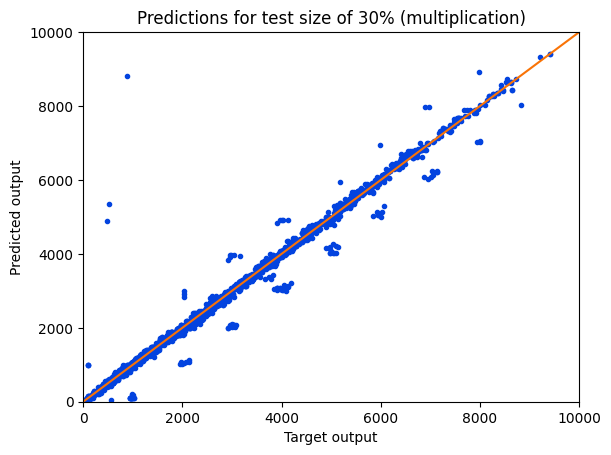

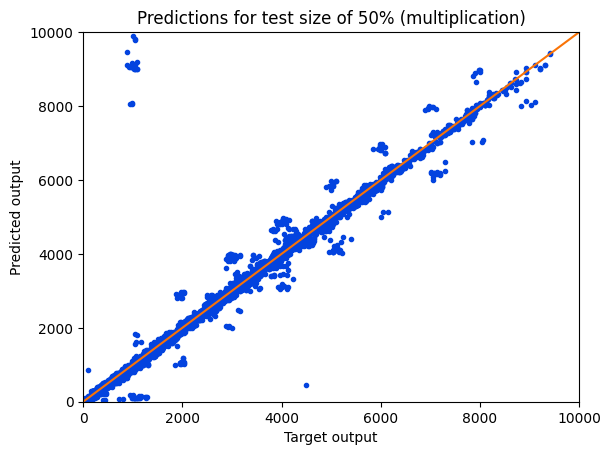

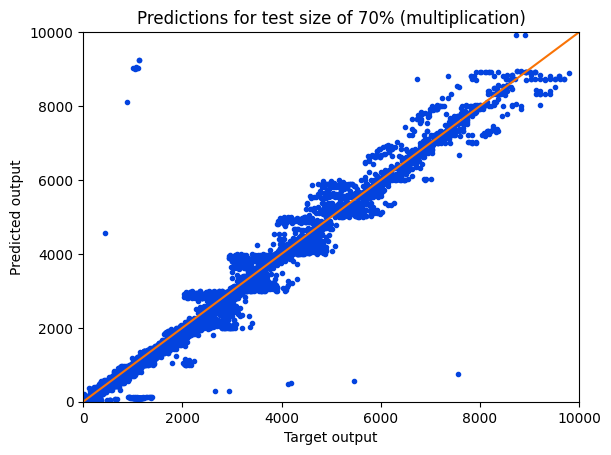

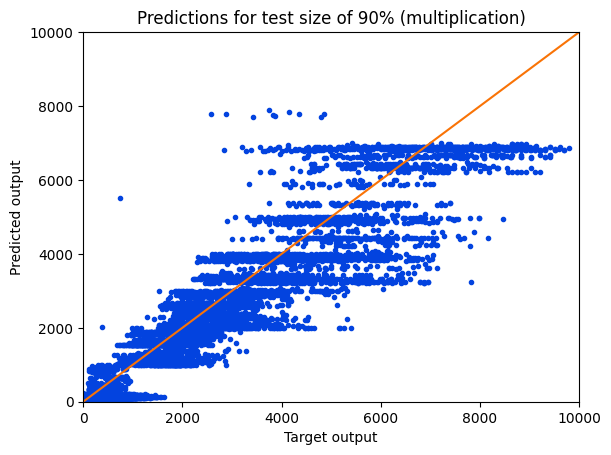

In [24]:
x = np.linspace(0, 10000, 50)

for i in range(len(test_sizes)):
  int_pred_mis_m, int_target_mis_m, non_ints_m = get_mismatches(predictions_data_m[i], y_test_data_m[i], unique_characters_m)

  plt.scatter(int_target_mis_m, int_pred_mis_m, marker='.', c='xkcd:blue')
  plt.plot(x, x, c='xkcd:orange')
  plt.title('Predictions for test size of ' + f'{test_sizes[i]:.0%}' + ' (multiplication)')
  plt.xlabel('Target output')
  plt.ylabel('Predicted output')
  plt.xlim([0, 10000])
  plt.ylim([0, 10000])
  plt.show()

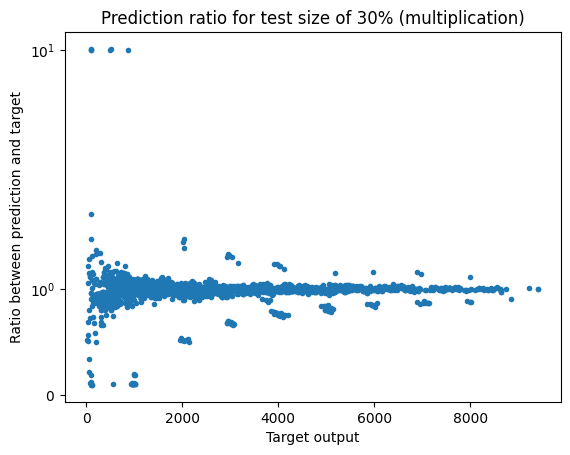

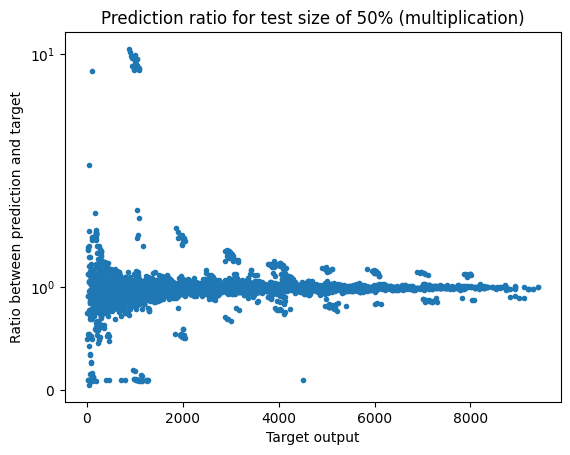

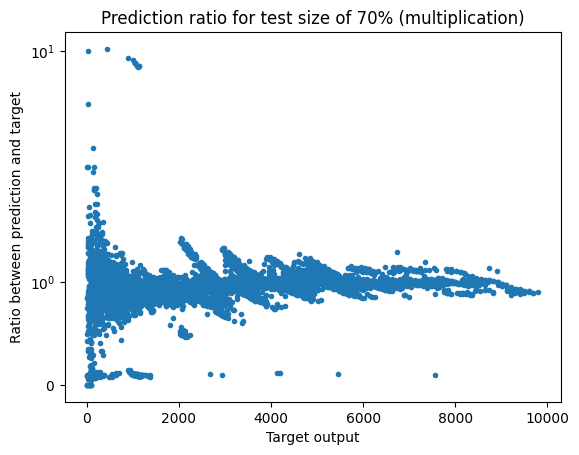

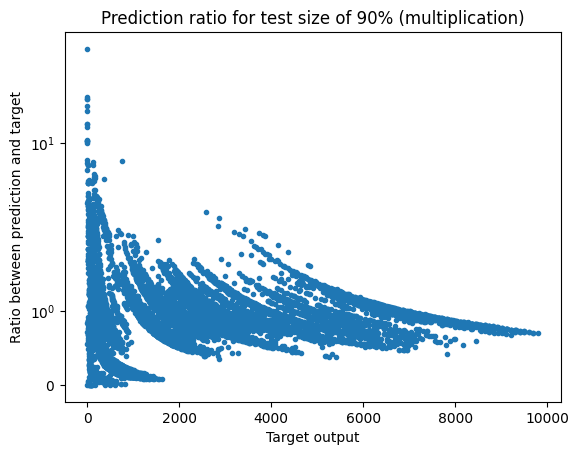

In [22]:
# Loop over each of the different test size model's data
for i in range(len(test_sizes)):
  int_pred_mis, int_target_mis, non_ints = get_mismatches(predictions_data_m[i], y_test_data_m[i], unique_characters_m)

  # Find the absolute difference between prediction and target
  ratio = []
  new_int_target_mis = []
  for j in range(len(int_pred_mis)):
    try:
      ratio.append(int_pred_mis[j] / int_target_mis[j])
      new_int_target_mis.append(int_target_mis[j])
    except ZeroDivisionError:
      continue

  plt.scatter(new_int_target_mis, ratio, marker='.')
  plt.title('Prediction ratio for test size of ' + f'{test_sizes[i]:.0%}' + ' (multiplication)')
  plt.yscale('symlog')
  plt.xlabel('Target output')
  plt.ylabel('Ratio between prediction and target')
  plt.show()